# **Data Preparation & Preprocessing**

## Import module

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, unicodedata, emoji
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from underthesea import word_tokenize


Set style for plot

In [2]:
sns.set_theme(
    style="whitegrid",
    context='notebook'
)

## Load & filter data

### Processing file

In [3]:
from typing import Any

def process_dataframe(df:dict[str, pd.DataFrame] | None, *process:Any):
    for key in df.keys():
        if process is None: continue
        for func in process:
            func(df, key)

In [4]:
def load_file(df:dict[str, pd.DataFrame], key:str):
    df[key] = pd.read_json(f'archive/UIT-VSFC-{key}.json')
    df[key] = df[key][(df[key]['topic'] == 'lecturer') & (df[key]['sentiment'] != 'neutral')].drop('topic', axis=1)
    df[key].reset_index(drop=True, inplace=True)
    print(f'{key.capitalize()} size: {df[key].shape}')
    display(df[key].head())

In [5]:
df = {
    'train': pd.DataFrame(),
    'dev': pd.DataFrame(),
    'test': pd.DataFrame()
}

try:
    process_dataframe(df, load_file)
except Exception as e:
    print(f"Errors: {e}")

Train size: (7980, 2)


,sentence,sentiment
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive


Dev size: (1119, 2)


,sentence,sentiment
0,giảng buồn ngủ .,negative
1,"giáo viên vui tính , tận tâm .",positive
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative


Test size: (2216, 2)


,sentence,sentiment
0,nói tiếng anh lưu loát .,positive
1,giáo viên rất vui tính .,positive
2,cô max có tâm .,positive
3,"giảng bài thu hút , dí dỏm .",positive
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative


### Label encoding

In [6]:
label_encoder = LabelEncoder()

df['train']['sentiment_encoded'] = label_encoder.fit_transform(df['train']['sentiment'])
df['dev']['sentiment_encoded'] = label_encoder.transform(df['dev']['sentiment'])
df['test']['sentiment_encoded'] = label_encoder.transform(df['test']['sentiment'])

for label, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded}")

print("Phân phối nhãn sau khi encode:")
print("Train:")
print(df['train']['sentiment_encoded'].value_counts().sort_index())
print("Dev:")
print(df['dev']['sentiment_encoded'].value_counts().sort_index())
print("Test:")
print(df['test']['sentiment_encoded'].value_counts().sort_index())

negative: 0
positive: 1
Phân phối nhãn sau khi encode:
Train:
sentiment_encoded
0    2909
1    5071
Name: count, dtype: int64
Dev:
sentiment_encoded
0    405
1    714
Name: count, dtype: int64
Test:
sentiment_encoded
0     791
1    1425
Name: count, dtype: int64


### EDA

Word cloud function

In [7]:
def getWordCloud(words, title):
    text = ' '.join(words)
    wordcloud = WordCloud(
        width=500,
        height=250,
        colormap='viridis',
        background_color='white',
        random_state=123
    ).generate(text)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20, pad=16, color="#222")
    plt.tight_layout(pad=0)
    plt.show()

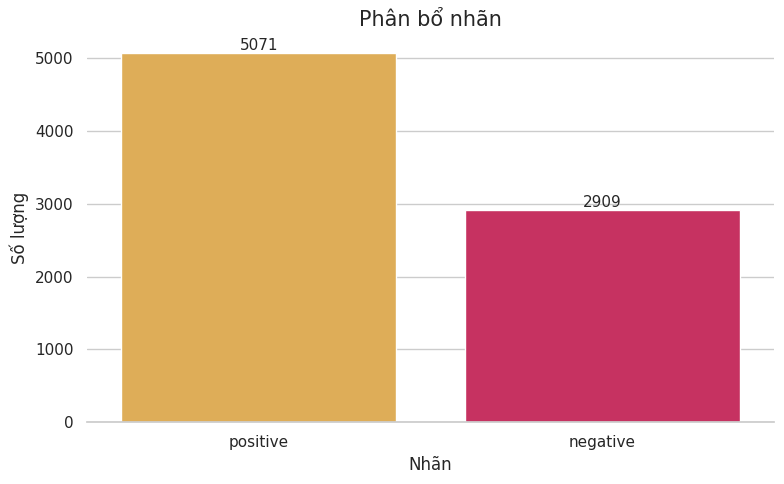

Quantity of each label:
positive: 5071 (63.55%)
negative: 2909 (36.45%)


In [8]:
sentiment_counts = df['train']['sentiment'].value_counts()

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    hue=sentiment_counts.index,
    palette={'positive': '#F4B342', 'negative': '#DE1A58'}
)
plt.xlabel('Nhãn', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.title('Phân bổ nhãn', fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

for i, count in enumerate(sentiment_counts.values):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=11)

sns.despine(left=True)
plt.tight_layout()
plt.show()

print("Quantity of each label:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count} ({count/len(df['train'])*100:.2f}%)")

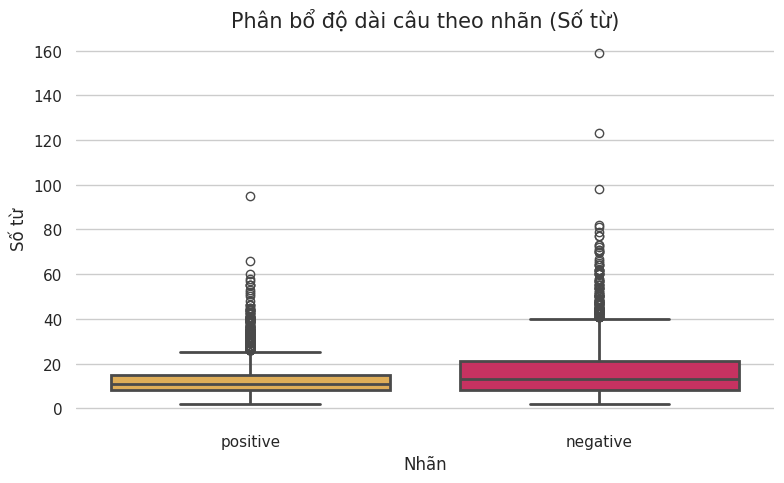

In [9]:
plt.figure(figsize=(8, 5))

df['train']['word_count'] = df['train']['sentence'].astype(str).apply(lambda x: len(x.split()))
ax = sns.boxplot(
    x='sentiment',
    y='word_count',
    data=df['train'],
    linewidth=2,
    hue='sentiment',
    palette={'positive': '#F4B342', 'negative': '#DE1A58'}
)

sns.despine(left=True, bottom=True)
ax.set_title('Phân bổ độ dài câu theo nhãn (Số từ)', fontsize=15)
ax.set_xlabel('Nhãn', fontsize=12)
ax.set_ylabel('Số từ', fontsize=12)
plt.tight_layout()
plt.show()

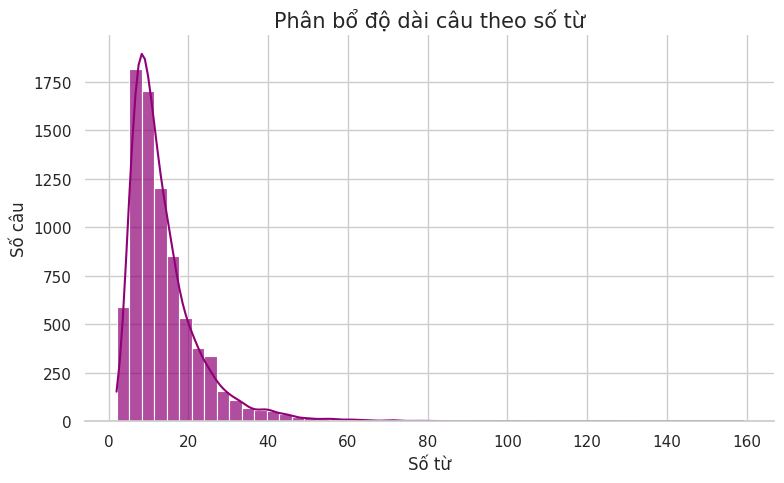

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df['train']['word_count'],
    color='#8F0177',
    bins=50,
    alpha=0.7,
    kde=True
)
plt.title('Phân bổ độ dài câu theo số từ', fontsize=15)
plt.xlabel('Số từ', fontsize=12)
plt.ylabel('Số câu', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.despine(left=True)
plt.tight_layout()
plt.show()


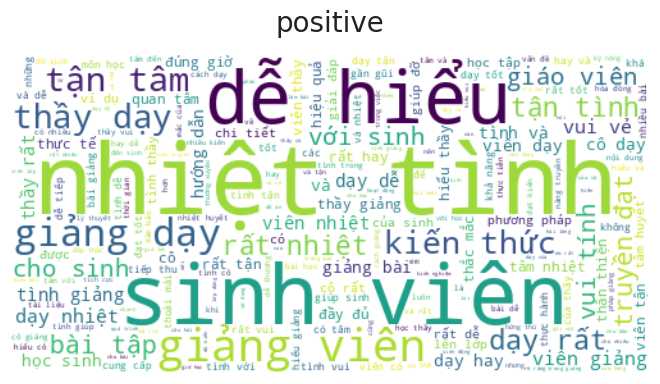

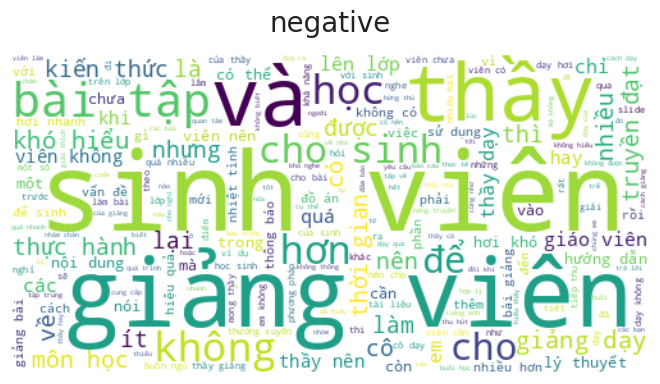

In [11]:
labels = df['train']['sentiment'].value_counts().index.tolist()

for label in labels:
    word_list = []

    for senc in df['train'][df['train']['sentiment'] == label]['sentence']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list, label)

In [12]:
stats_words = df['train'].groupby('sentiment')['word_count'].agg(['mean', 'median', 'std', 'min', 'max']).round(2)
stats_words.columns = ['Trung bình', 'Trung vị', 'Độ lệch chuẩn', 'Tối thiểu', 'Tối đa']

print("Thống kê số từ theo nhãn:")
display(stats_words)

Thống kê số từ theo nhãn:


,Trung bình,Trung vị,Độ lệch chuẩn,Tối thiểu,Tối đa
sentiment,,,,,
negative,16.37,13.0,11.77,2,159
positive,12.37,11.0,7.00,2,95


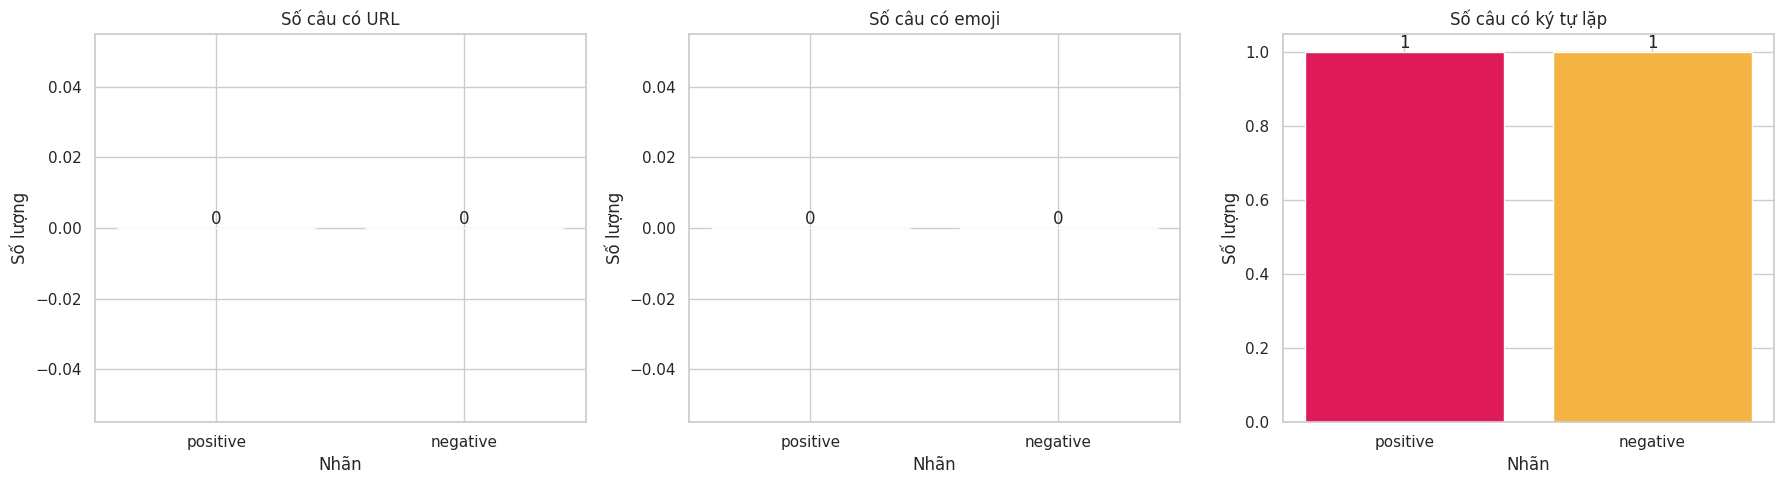

In [13]:
def has_url(text):
    if not isinstance(text, str):
        return False

    url_pattern = r'https?://\S+|www\.\S+'
    return bool(re.search(url_pattern, text))

def has_emoji(text):
    if not isinstance(text, str):
        return False

    try:
        return emoji.emoji_count(text) > 0
    except:
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+",
            flags=re.UNICODE
        )

        return bool(emoji_pattern.search(text))

def has_repeated_chars(text):
    if not isinstance(text, str):
        return False

    return bool(re.search(r'(.)\1{2,}', text))

# Không thêm cột! Xử lý và tổng hợp trên-the-fly
feature_funcs = [("URL", has_url), ("emoji", has_emoji), ("ký tự lặp", has_repeated_chars)]
special_features = {}
for label in df['train']['sentiment'].unique():
    mask = df['train']['sentiment'] == label
    sent_texts = df['train'].loc[mask, 'sentence']
    for feat_name, feat_func in feature_funcs:
        count = sent_texts.apply(feat_func).sum()
        special_features.setdefault(feat_name, {})[label] = count

special_features_df = pd.DataFrame(special_features).fillna(0).astype(int)
special_features_df = special_features_df.reindex(df['train']['sentiment'].unique())

# Visualize bằng bar chart mà không cần cột trong dataframe
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_name, _) in enumerate(feature_funcs):
    feature_counts = special_features_df[feat_name]
    axes[idx].bar(feature_counts.index, feature_counts.values, color=sns.color_palette({'#F4B342', '#DE1A58'}, len(feature_counts)))
    axes[idx].set_title(f'Số câu có {feat_name}')
    axes[idx].set_xlabel('Nhãn')
    axes[idx].set_ylabel('Số lượng')
    for i, v in enumerate(feature_counts.values):
        axes[idx].text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Pre-processing text

Xử lý dấu câu

In [14]:
import string

def remove_punctuation(text:str) -> str:
    return text.translate(str.maketrans('', '', string.punctuation))

Stop words

In [15]:
path_stop = "archive/vietnamese-stopwords.txt"
stopword_set = set(open(path_stop, 'r', encoding='utf-8').read().splitlines())
stopword_set = [w.replace(' ', '_') for w in stopword_set]

def normalize_stopwords(text: str):
    tokens = text.split()
    result = []
    for word in tokens:
        word_clean = word.strip(string.punctuation)

        if word_clean not in stopword_set:
            result.append(word)

    return ' '.join(result)

Normalize unicode

In [16]:
def normalize_unicode(text:str):
    return unicodedata.normalize('NFC', text)

Duplicate characters handling

In [17]:
def remove_duplicate_characters(text:str):
    return re.sub(r'(.)\1+', r'\1', text)

Dataset specific regex

In [18]:
def remove_specific_unnormalized(text:str):
    return re.sub(r'wzjwz\d+', ' ', text)

In [19]:
def preprocess_text(text):
    if not isinstance(text, str): return ""
    text = text.lower().strip() # Lowercasing & Processing space
    text = normalize_unicode(text)
    text = remove_specific_unnormalized(text)
    text = remove_duplicate_characters(text)
    text = remove_punctuation(text)
    text = word_tokenize(text, format="text")
    text = normalize_stopwords(text)
    return text

Áp dụng các biện pháp xử lý

In [20]:
df['train']["sentence_process"] = df['train']["sentence"].apply(preprocess_text)
df['dev']["sentence_process"] = df['dev']["sentence"].apply(preprocess_text)
df['test']["sentence_process"] = df['test']["sentence"].apply(preprocess_text)

display(df['train'].head())
display(df['dev'].head())
display(df['test'].head())

,sentence,sentiment,sentiment_encoded,word_count,sentence_process
0,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,1,11,nhiệt_tình gần_gũi
1,chưa áp dụng công nghệ thông tin và các thiết ...,negative,0,18,chưa áp_dụng công_nghệ_thông_tin thiết_bị hỗ_trợ
2,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,1,15,giảng hay có nhiều bài_tập ví_dụ ngay
3,"giảng viên đảm bảo thời gian lên lớp , tích cự...",positive,1,28,đảm_bảo thời_gian tích_cực trả_lời câu hỏi thư...
4,thầy rất tận tình và đi dạy rất đúng giờ .,positive,1,11,rất tận_tình rất đúng giờ


,sentence,sentiment,sentiment_encoded,sentence_process
0,giảng buồn ngủ .,negative,0,giảng buồn ngủ
1,"giáo viên vui tính , tận tâm .",positive,1,vui_tính tận_tâm
2,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative,0,giao bài_tập nhiều hơn chia làm bài_tập giảng_...
3,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative,0,cần giảng chi_tiết hơn đi_sâu hơn code chạy th...
4,nên có giảng viên nước ngoài dạy để sinh viên ...,negative,0,có nước_ngoài có cơ_hội giao_tiếp


,sentence,sentiment,sentiment_encoded,sentence_process
0,nói tiếng anh lưu loát .,positive,1,nói tiếng lưu_loát
1,giáo viên rất vui tính .,positive,1,rất vui_tính
2,cô max có tâm .,positive,1,max có tâm
3,"giảng bài thu hút , dí dỏm .",positive,1,giảng thu_hút dí dỏm
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",negative,0,không kiến_thức hướng_dẫn quá_trình


### Sau tiền xử lý

Word Cloud

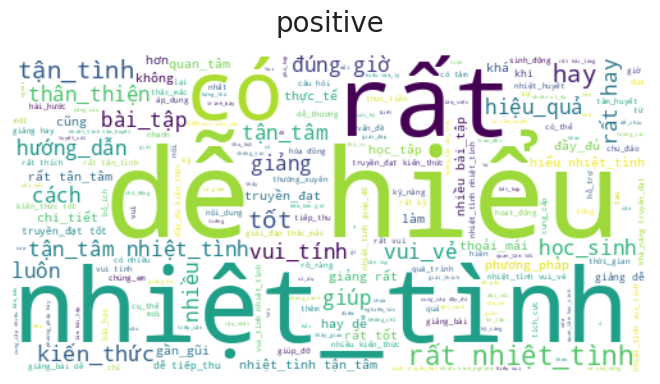

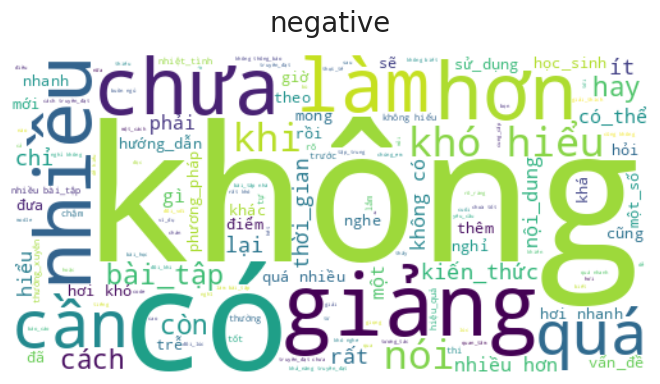

In [21]:
labels = df['train']['sentiment'].value_counts().index.tolist()

for label in labels:
    word_list = []

    for senc in df['train'][df['train']['sentiment'] == label]['sentence_process']:
        if isinstance(senc, list):
            merged = ' '.join(senc)
        else:
            merged = senc
        word_list.append(merged)

    getWordCloud(word_list, label)

## Feature Extraction

TF-IDF vs N-grams

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
X_train = df['train']['sentence_process']
X_dev = df['dev']['sentence_process']
X_test = df['test']['sentence_process']

In [24]:
y_train = df['train']['sentiment_encoded']
y_dev = df['dev']['sentiment_encoded']
y_test = df['test']['sentiment_encoded']

In [25]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [26]:
print(f"Kích thước tập huấn luyện (Training Set): {X_train_tfidf.shape}")
print(f"Kích thước tập huấn luyện (Validation Set): {X_dev_tfidf.shape}")
print(f"Kích thước tập kiểm thử (Test Set): {X_test_tfidf.shape}")
print(f"Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: {X_train_tfidf.shape[1]}")

Kích thước tập huấn luyện (Training Set): (7980, 4148)
Kích thước tập huấn luyện (Validation Set): (1119, 4148)
Kích thước tập kiểm thử (Test Set): (2216, 4148)
Tổng số đặc trưng (từ vựng và n-grams) được sử dụng: 4148


# **Training model**

## Import module

In [27]:
import time
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import learning_curve

Models configuration

In [28]:
models = {
    'Lo.R': {
        'instance': LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear',
            n_jobs=-1
        ),
        'threshold': 0.5
    },
    'Naive Bayes': {
        'instance': MultinomialNB(),
        'threshold': 0.5
    },
    'Linear-SVM': {
        'instance': LinearSVC(
            class_weight='balanced',
            max_iter=1000,
            dual=False
        ),
        'threshold': 0.5
    }
}

### Train models

In [29]:
# Dictionary to store trained models and results
trained_models = {}
results = {}

print("Training models...")

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train the model
    model = model_info['instance']
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_dev_pred = model.predict(X_dev_tfidf)
    y_test_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    results[name] = {
        'train': {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred, average='weighted'),
            'recall': recall_score(y_train, y_train_pred, average='weighted'),
            'f1': f1_score(y_train, y_train_pred, average='weighted')
        },
        'dev': {
            'accuracy': accuracy_score(y_dev, y_dev_pred),
            'precision': precision_score(y_dev, y_dev_pred, average='weighted'),
            'recall': recall_score(y_dev, y_dev_pred, average='weighted'),
            'f1': f1_score(y_dev, y_dev_pred, average='weighted')
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, average='weighted'),
            'recall': recall_score(y_test, y_test_pred, average='weighted'),
            'f1': f1_score(y_test, y_test_pred, average='weighted')
        },
        'predictions': {
            'train': y_train_pred,
            'dev': y_dev_pred,
            'test': y_test_pred
        },
        'training_time': training_time
    }

print("All models trained successfully!")


Training models...

Training Lo.R...
Training completed in 0.02 seconds

Training Naive Bayes...
Training completed in 0.00 seconds

Training Linear-SVM...
Training completed in 0.02 seconds
All models trained successfully!


/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


## Evaluation

### Results comparison

In [30]:
# Create results DataFrame for comparison
comparison_data = []
for model_name, result in results.items():
    for dataset in ['train', 'dev', 'test']:
        comparison_data.append({
            'Model': model_name,
            'Dataset': dataset,
            'Accuracy': result[dataset]['accuracy'],
            'Precision': result[dataset]['precision'],
            'Recall': result[dataset]['recall'],
            'F1-Score': result[dataset]['f1']
        })

results_df = pd.DataFrame(comparison_data)
display(results_df)

,Model,Dataset,Accuracy,Precision,Recall,F1-Score
0,Lo.R,train,0.953509,0.955266,0.953509,0.953804
1,Lo.R,dev,0.949062,0.950119,0.949062,0.949302
2,Lo.R,test,0.922834,0.927048,0.922834,0.923600
3,Naive Bayes,train,0.947118,0.947651,0.947118,0.947273
4,Naive Bayes,dev,0.938338,0.938372,0.938338,0.938354
5,Naive Bayes,test,0.918773,0.920149,0.918773,0.919176
6,Linear-SVM,train,0.983208,0.983526,0.983208,0.983256
7,Linear-SVM,dev,0.954424,0.954401,0.954424,0.954411
8,Linear-SVM,test,0.925993,0.928652,0.925993,0.926565


/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: F

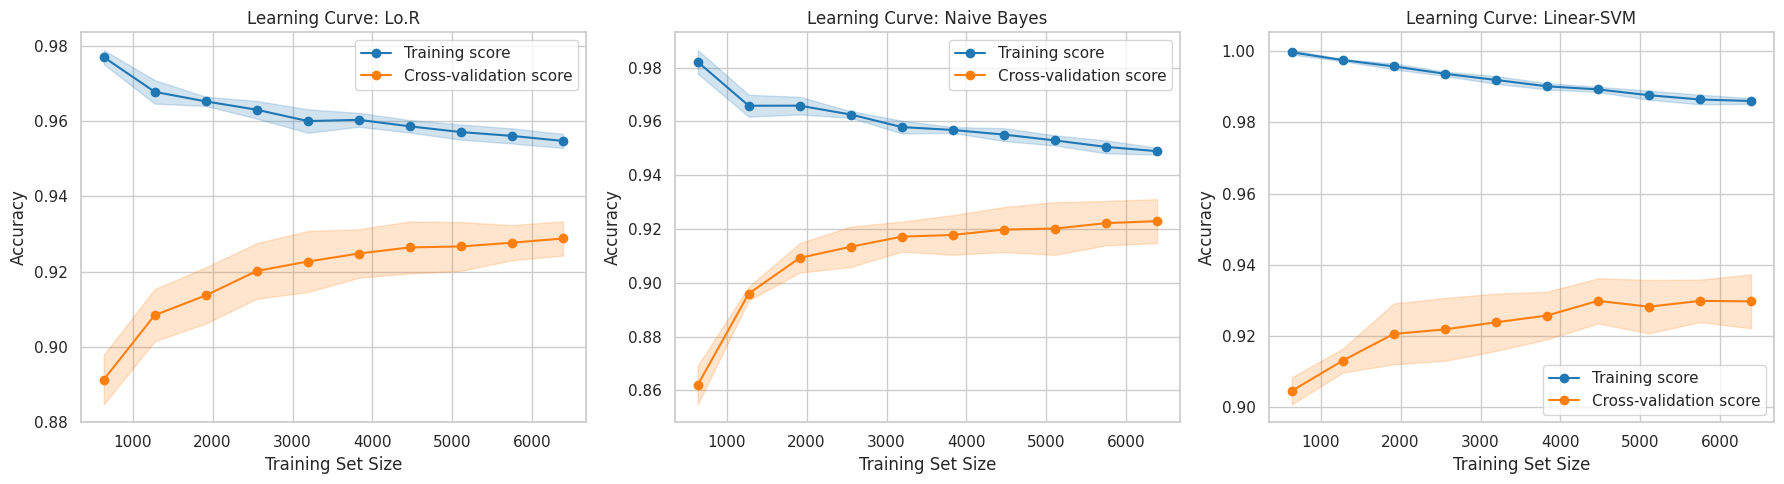

In [31]:
plt.figure(figsize=(18, 5))

for idx, (model_name, model) in enumerate(trained_models.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train_tfidf,
        y_train,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, len(trained_models), idx + 1)
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="tab:blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="tab:orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="tab:blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="tab:orange", label="Cross-validation score")
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Detailed classification reports

In [32]:
for model_name in trained_models.keys():
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    for dataset_name, y_true, y_pred in [
        ('Train', y_train, results[model_name]['predictions']['train']),
        ('Dev', y_dev, results[model_name]['predictions']['dev']),
        ('Test', y_test, results[model_name]['predictions']['test'])
    ]:
        print(f"{dataset_name} Set Classification Report:")
        print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))


Model: Lo.R
Train Set Classification Report:
              precision    recall  f1-score   support

    negative     0.9091    0.9694    0.9383      2909
    positive     0.9818    0.9444    0.9627      5071

    accuracy                         0.9535      7980
   macro avg     0.9454    0.9569    0.9505      7980
weighted avg     0.9553    0.9535    0.9538      7980

Dev Set Classification Report:
              precision    recall  f1-score   support

    negative     0.9104    0.9531    0.9312       405
    positive     0.9727    0.9468    0.9595       714

    accuracy                         0.9491      1119
   macro avg     0.9415    0.9499    0.9454      1119
weighted avg     0.9501    0.9491    0.9493      1119

Test Set Classification Report:
              precision    recall  f1-score   support

    negative     0.8547    0.9444    0.8973       791
    positive     0.9672    0.9109    0.9382      1425

    accuracy                         0.9228      2216
   macro avg     0.

### Confusion matrices

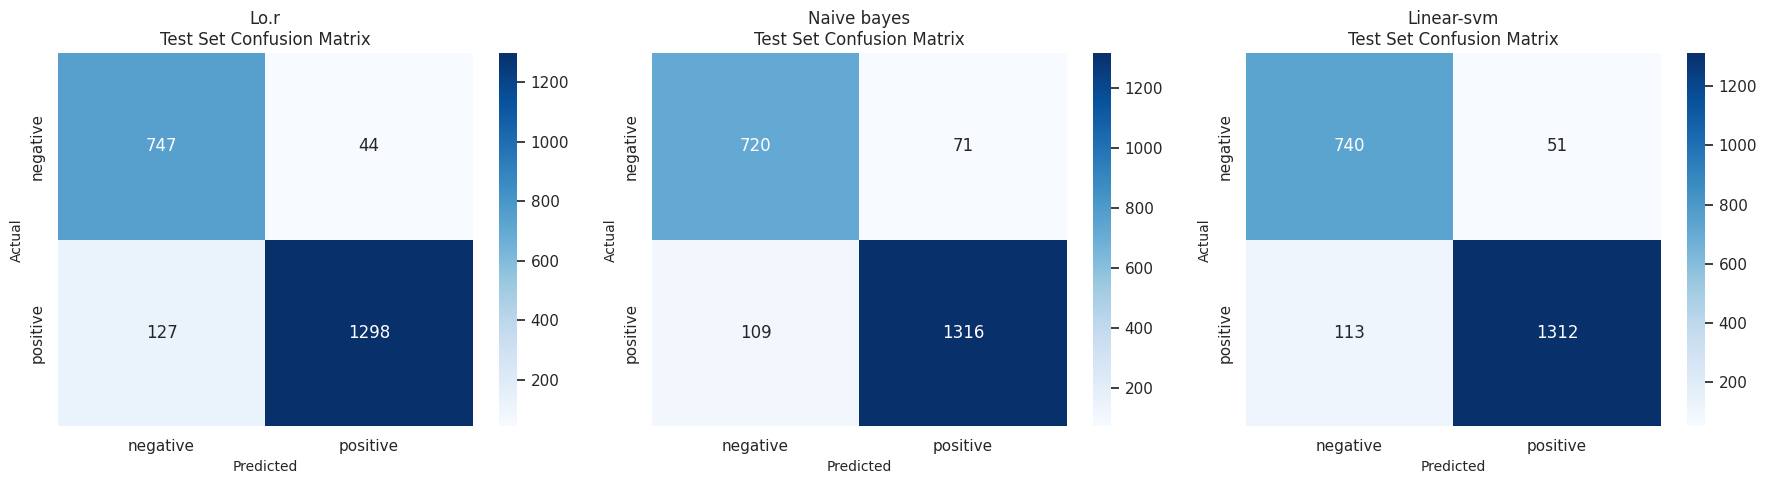

In [33]:
# Plot confusion matrices for test set
fig, axes = plt.subplots(1, len(trained_models), figsize=(6*len(trained_models), 5))

if len(trained_models) == 1:
    axes = [axes]

for idx, (model_name, model) in enumerate(trained_models.items()):
    y_test_pred = results[model_name]['predictions']['test']
    cm = confusion_matrix(y_test, y_test_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[idx].set_title(f'{model_name.capitalize()}\nTest Set Confusion Matrix', 
                        fontsize=12)
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.show()


## Hyperparameter Tuning cho 3 mô hình
Thực hiện GridSearchCV cho Logistic Regression, Linear SVM và Multinomial Naive Bayes.
So sánh hiệu quả dựa trên F1-score.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [35]:
model_configs = {
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(min_df=3)),
            ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1))
        ]),
        'threshold': 0.5
    },
    'Naive Bayes': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(min_df=3)),
            ('clf', MultinomialNB())
        ]),
        'threshold': 0.5
    },
    'Linear SVM': {
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(min_df=3)),
            ('clf', LinearSVC(class_weight='balanced', max_iter=5000, dual='auto'))
        ]),
        'threshold': 0.5
    }
}

param_grids = {
    'Logistic Regression': {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__use_idf': [True, False],
        'clf__C': [0.1, 1, 10, 100],
        'clf__solver': ['liblinear', 'lbfgs']
    },
    'Naive Bayes': {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__max_features': [None, 5000, 10000],
        'clf__alpha': [0.001, 0.01, 0.1, 1, 10]
    },
    'Linear SVM': {
        'tfidf__ngram_range': [(1, 2), (1, 3)],
        'tfidf__norm': ['l1', 'l2'],
        'clf__C': [0.1, 0.5, 1, 5, 10],
        'clf__loss': ['hinge', 'squared_hinge']
    }
}

In [36]:
best_tuned_configs = {}
tuning_results = []

print("Đang thực hiện Grid Search cho các Pipeline\n")

for name, config in model_configs.items():
    print(f"Tuning {name}...")
    
    grid_search = GridSearchCV(
        config['pipeline'], 
        param_grids[name], 
        cv=5, 
        scoring='f1_weighted', 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(df['train']['sentence_process'], y_train)
    
    # Lưu lại kết quả gồm Pipeline tốt nhất và Threshold mặc định
    best_tuned_configs[name] = {
        'pipeline': grid_search.best_estimator_,
        'threshold': config['threshold'] 
    }
    
    tuning_results.append({
        'Model': name,
        'Best_F1': grid_search.best_score_,
        'Params': grid_search.best_params_
    })

print("\nTuning hoàn tất!")

Đang thực hiện Grid Search cho các Pipeline

Tuning Logistic Regression...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/gemini/.pyenv/versions/3.12.9/envs/ai-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: F

Tuning Naive Bayes...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Tuning Linear SVM...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Tuning hoàn tất!


In [37]:
from sklearn.metrics import precision_recall_curve

def optimize_model_thresholds(configs, X_val, y_val):
    for name, config in configs.items():
        pipeline = config['pipeline']
        
        # Lấy xác suất
        if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
            y_probs = pipeline.predict_proba(X_val)[:, 1]
        else:
            # Cho SVM
            d = pipeline.decision_function(X_val)
            y_probs = 1 / (1 + np.exp(-d))
            
        # Tìm threshold tốt nhất bằng Precision-Recall Curve
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        best_idx = np.argmax(f1_scores)
        
        # Cập nhật threshold mới vào config
        new_threshold = thresholds[best_idx]
        configs[name]['threshold'] = new_threshold
        
        print(f"Model {name:20}: Ngưỡng mới = {new_threshold:.4f} (F1-Dev = {f1_scores[best_idx]:.4f})")

# Chạy tối ưu hóa
optimize_model_thresholds(best_tuned_configs, df['dev']['sentence_process'], y_dev)

Model Logistic Regression : Ngưỡng mới = 0.4425 (F1-Dev = 0.9659)
Model Naive Bayes         : Ngưỡng mới = 0.4638 (F1-Dev = 0.9536)
Model Linear SVM          : Ngưỡng mới = 0.4600 (F1-Dev = 0.9638)


In [38]:
# 1. Tạo DataFrame từ danh sách kết quả tuning
tuning_summary_df = pd.DataFrame(tuning_results)

print("GRID SEARCH")
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    display(tuning_summary_df.sort_values(by='Best_F1', ascending=False))

print("\nBảng metrics trên tập train/dev/test sau khi đã tuning:")
comparison_data = []
for model_name, result in results.items():
    for dataset in ['train', 'dev', 'test']:
        comparison_data.append({
            'Model': model_name,
            'Dataset': dataset,
            'Accuracy': result[dataset]['accuracy'],
            'Precision': result[dataset]['precision'],
            'Recall': result[dataset]['recall'],
            'F1-Score': result[dataset]['f1']
        })

results_df = pd.DataFrame(comparison_data)
display(results_df)

# 3. Xác định Model quán quân (Best of the best)
# Sử dụng idxmax trên cột 'Best_F1'
best_model_row = tuning_summary_df.loc[tuning_summary_df['Best_F1'].idxmax()]
best_model_name = best_model_row['Model']

# Lấy thông tin từ dict best_tuned_configs (đã bao gồm pipeline và threshold tối ưu)
winning_config = best_tuned_configs[best_model_name]
best_model = winning_config['pipeline']
optimal_threshold = winning_config['threshold']

print(f"\nMODEL TỐT NHẤT: {best_model_name.upper()}")
print(f"   - F1-Score (Validation): {best_model_row['Best_F1']:.4f}")
print(f"   - Ngưỡng tối ưu (Optimal Threshold): {optimal_threshold:.4f}")
print(f"   - Tham số tốt nhất: {best_model_row['Params']}")

GRID SEARCH


,Model,Best_F1,Params
2,Linear SVM,0.933427,"{'clf__C': 1, 'clf__loss': 'hinge', 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}"
0,Logistic Regression,0.930490,"{'clf__C': 10, 'clf__solver': 'lbfgs', 'tfidf__ngram_range': (1, 3), 'tfidf__use_idf': True}"
1,Naive Bayes,0.922447,"{'clf__alpha': 1, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 3)}"



Bảng metrics trên tập train/dev/test sau khi đã tuning:


,Model,Dataset,Accuracy,Precision,Recall,F1-Score
0,Lo.R,train,0.953509,0.955266,0.953509,0.953804
1,Lo.R,dev,0.949062,0.950119,0.949062,0.949302
2,Lo.R,test,0.922834,0.927048,0.922834,0.923600
3,Naive Bayes,train,0.947118,0.947651,0.947118,0.947273
4,Naive Bayes,dev,0.938338,0.938372,0.938338,0.938354
5,Naive Bayes,test,0.918773,0.920149,0.918773,0.919176
6,Linear-SVM,train,0.983208,0.983526,0.983208,0.983256
7,Linear-SVM,dev,0.954424,0.954401,0.954424,0.954411
8,Linear-SVM,test,0.925993,0.928652,0.925993,0.926565



MODEL TỐT NHẤT: LINEAR SVM
   - F1-Score (Validation): 0.9334
   - Ngưỡng tối ưu (Optimal Threshold): 0.4600
   - Tham số tốt nhất: {'clf__C': 1, 'clf__loss': 'hinge', 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


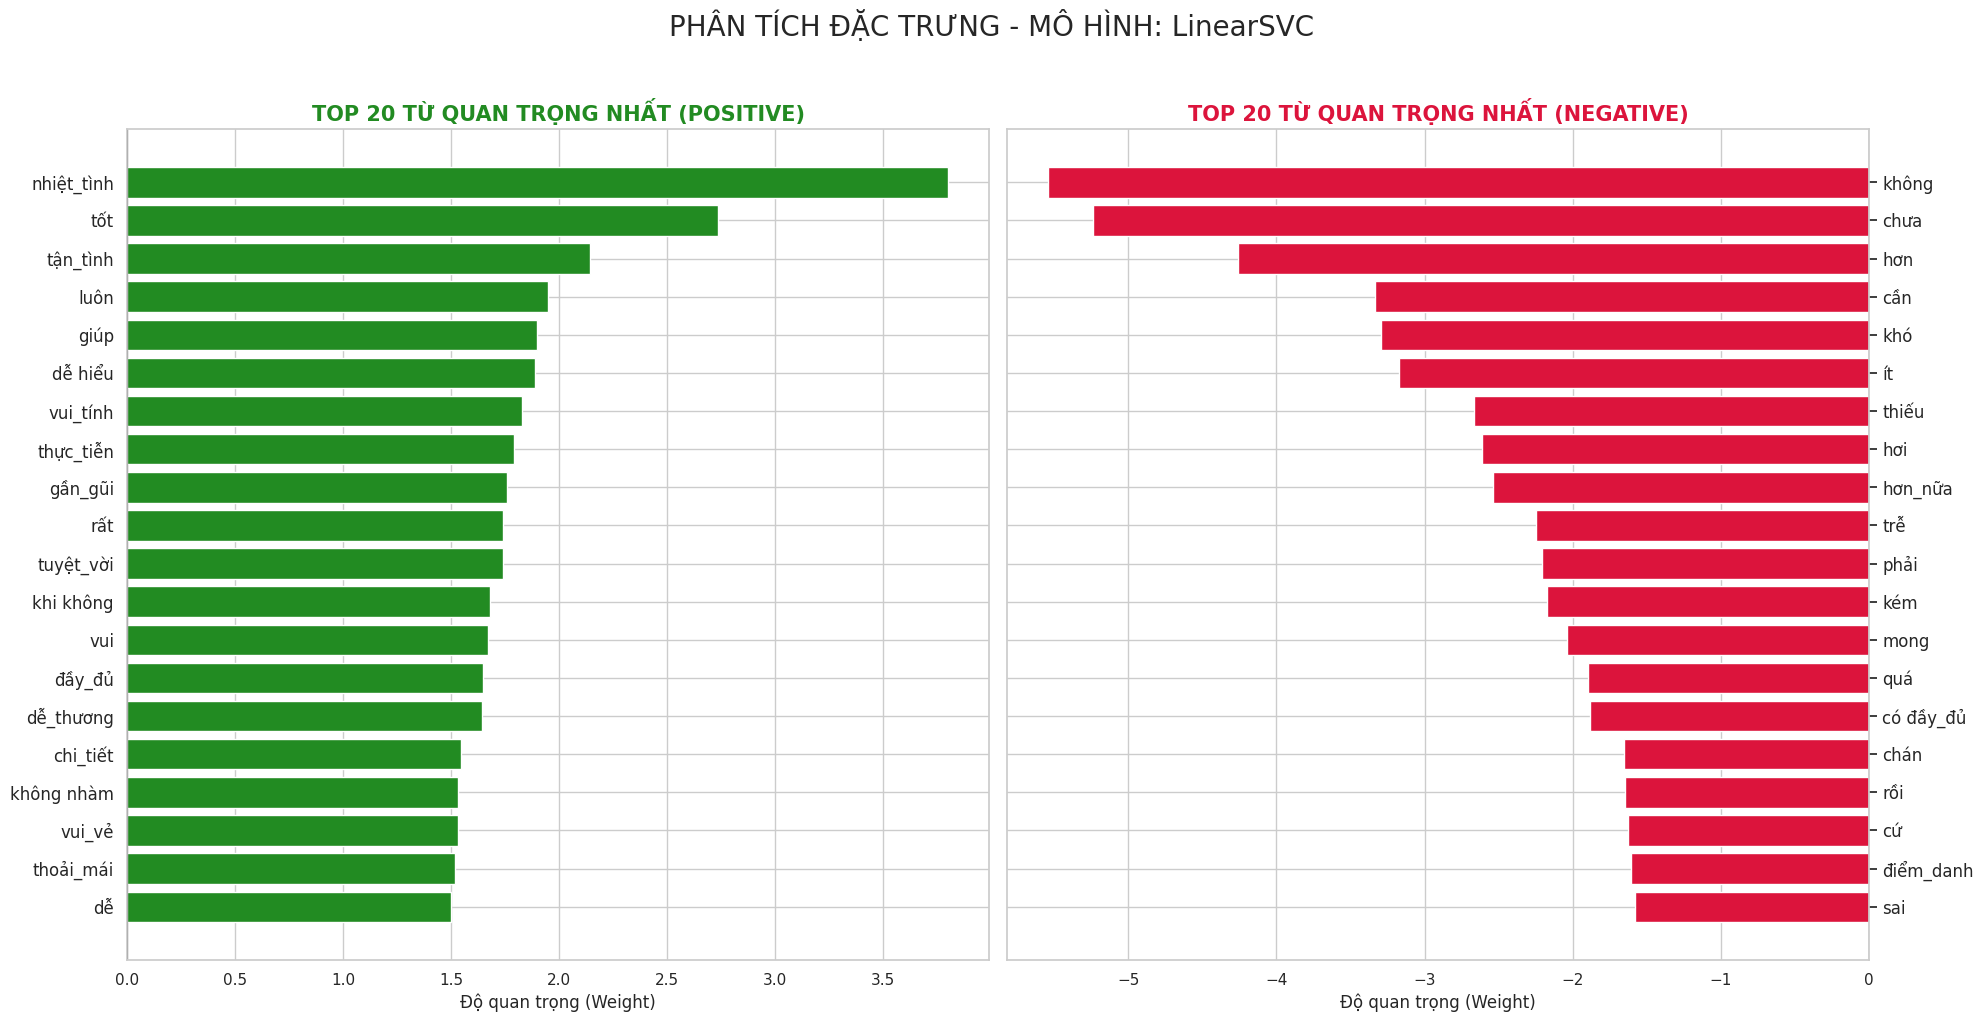

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

def plot_class_specific_features_v2(pipeline_model, n=20):
    # 1. Tách Vectorizer và Classifier từ Pipeline
    if isinstance(pipeline_model, Pipeline):
        vectorizer = pipeline_model.named_steps['tfidf']
        classifier = pipeline_model.named_steps['clf']
    else:
        print("Lỗi: Đối tượng truyền vào không phải là Pipeline.")
        return

    # 2. Lấy tên các đặc trưng (từ vựng)
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # 3. Lấy trọng số (Coefficients) dựa trên loại Model
    if hasattr(classifier, 'coef_'):
        # Dành cho SVM và Logistic Regression
        coefs = classifier.coef_.toarray()[0] if hasattr(classifier.coef_, 'toarray') else classifier.coef_[0]
    elif hasattr(classifier, 'feature_log_prob_'):
        # Dành cho Naive Bayes (Sử dụng chênh lệch log probability giữa 2 nhãn)
        # Nhãn 1 (Positive) - Nhãn 0 (Negative)
        coefs = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    else:
        print(f"Model {type(classifier).__name__} không hỗ trợ trích xuất trọng số đặc trưng.")
        return

    # 4. Xác định các chỉ số (indices) của đặc trưng hàng đầu
    top_pos_indices = np.argsort(coefs)[-n:][::-1] # Giảm dần
    top_neg_indices = np.argsort(coefs)[:n]        # Tăng dần (âm nhất lên đầu)
    
    # 5. Khởi tạo biểu đồ
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # --- Biểu đồ 1: Positive Features (Màu xanh) ---
    axes[0].barh(range(n), coefs[top_pos_indices], color='forestgreen', align='center')
    axes[0].set_yticks(range(n))
    axes[0].set_yticklabels(feature_names[top_pos_indices], fontsize=12)
    axes[0].invert_yaxis()
    axes[0].set_title(f"TOP {n} TỪ QUAN TRỌNG NHẤT (POSITIVE)", fontsize=15, fontweight='bold', color='forestgreen')
    axes[0].set_xlabel("Độ quan trọng (Weight)")
    axes[0].axvline(0, color='black', linewidth=0.8)

    # --- Biểu đồ 2: Negative Features (Màu đỏ) ---
    axes[1].barh(range(n), coefs[top_neg_indices], color='crimson', align='center')
    axes[1].set_yticks(range(n))
    axes[1].set_yticklabels(feature_names[top_neg_indices], fontsize=12)
    axes[1].invert_yaxis()
    axes[1].set_title(f"TOP {n} TỪ QUAN TRỌNG NHẤT (NEGATIVE)", fontsize=15, fontweight='bold', color='crimson')
    axes[1].set_xlabel("Độ quan trọng (Weight)")
    axes[1].axvline(0, color='black', linewidth=0.8)
    axes[1].yaxis.tick_right() # Đưa nhãn chữ sang bên phải cho cân đối
    
    plt.suptitle(f"PHÂN TÍCH ĐẶC TRƯNG - MÔ HÌNH: {type(classifier).__name__}", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

try:
    plot_class_specific_features_v2(best_model, n=20)
except Exception as e:
    print(f"Có lỗi xảy ra: {e}")
    print("Mẹo: Đảm bảo bạn đã chạy cell 'final_best_model' trước đó.")

## Test


In [40]:
def predict_batch(texts, model_name=None):
    """
    Dự đoán sentiment cho nhiều câu cùng lúc bằng các mô hình đã Tuning (Pipeline).
    
    Parameters:
    -----------
    texts : list of str
        Danh sách các câu văn bản gốc cần dự đoán
    model_name : str, optional
        Tên mô hình ('Linear SVM', 'Logistic Regression', 'Naive Bayes'). 
        Nếu None, sử dụng best_model tốt nhất.
    """
    # 1. Chọn model
    if model_name is None:
        model = best_model  # Pipeline tốt nhất
        current_name = best_model_name
    else:
        # Sử dụng từ điển best_tuned_configs đã tuning ở bước trước
        if model_name not in best_tuned_configs:
            raise ValueError(f"Model '{model_name}' không tìm thấy. Danh sách: {list(best_tuned_configs.keys())}")
        model = best_tuned_configs[model_name]['pipeline']
        current_name = model_name
    
    # 2. Tiền xử lý văn bản
    # Sử dụng hàm preprocess_text đã định nghĩa ở phần đầu notebook
    # Lưu ý: Truyền vào biến stopwords nếu hàm của bạn yêu cầu
    processed_texts = [preprocess_text(text) for text in texts]
    
    # 3. Dự đoán (Pipeline tự động Vectorize văn bản đã qua xử lý)
    predictions = model.predict(processed_texts)
    sentiment_labels = label_encoder.inverse_transform(predictions)

    # 4. Tính toán xác suất (Probabilities)
    probabilities = None
    
    # Một số model không có predict_proba (như LinearSVC), cần dùng decision_function
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(processed_texts)
    elif hasattr(model, 'decision_function'):
        # Chuyển đổi score từ decision_function sang dạng xác suất xấp xỉ
        decisions = model.decision_function(processed_texts)
        if len(decisions.shape) == 1: # Nhị phân
            probabilities = []
            for d in decisions:
                # Công thức sigmoid xấp xỉ để đưa về khoảng [0, 1]
                p = 1 / (1 + np.exp(-d))
                probabilities.append([1-p, p])
            probabilities = np.array(probabilities)
        else: # Đa lớp (nếu có)
            exp_decisions = np.exp(decisions)
            probabilities = exp_decisions / np.sum(exp_decisions, axis=1, keepdims=True)

    # 5. Đóng gói kết quả vào DataFrame
    results = pd.DataFrame({
        'Text': texts,
        'Processed Text': processed_texts,
        'Predicted Sentiment': sentiment_labels,
        'Model Used': current_name
    })

    # Thêm các cột xác suất nếu có
    if probabilities is not None:
        for idx, label in enumerate(label_encoder.classes_):
            results[f'Probability_{label}'] = probabilities[:, idx]
    
    return results

# --- TEST THỬ VỚI CÁC CÂU MỚI ---
test_sentences = [
    "Thầy dạy rất hay và nhiệt tình",
    "Bài giảng hơi buồn ngủ, cần cải thiện thêm",
    "Cơ sở vật chất của trường rất tuyệt vời",
    "Giảng viên thường xuyên đi muộn"
]

# Chạy dự đoán bằng best model
final_predictions = predict_batch(test_sentences)
display(final_predictions)

,Text,Processed Text,Predicted Sentiment,Model Used,Probability_negative,Probability_positive
0,Thầy dạy rất hay và nhiệt tình,rất hay nhiệt_tình,positive,Linear SVM,0.050269,0.949731
1,"Bài giảng hơi buồn ngủ, cần cải thiện thêm",giảng_hơi buồn_ngủ cần cải_thiện thêm,negative,Linear SVM,0.842933,0.157067
2,Cơ sở vật chất của trường rất tuyệt vời,cơ_sở vật_chất rất tuyệt_vời,positive,Linear SVM,0.186798,0.813202
3,Giảng viên thường xuyên đi muộn,thường_xuyên muộn,negative,Linear SVM,0.741844,0.258156


In [41]:
batch_texts = [
    "Giảng viên rất nhiệt tình và có phương pháp giảng dạy tốt",
    "Thầy cô không quan tâm đến học sinh",
    "Bài giảng rất hay và dễ hiểu",
    "Giảng viên thường xuyên đi muộn",
    "Cô giáo rất vui tính và tạo không khí học tập tích cực",
    "Thầy rất hay đến muộn",
    "Thầy hay đến muộn, giao rất nhiều bài tập cho học sinh"
]

batch_results = predict_batch(batch_texts)
display(batch_results)

,Text,Processed Text,Predicted Sentiment,Model Used,Probability_negative,Probability_positive
0,Giảng viên rất nhiệt tình và có phương pháp gi...,rất nhiệt_tình có phương_pháp tốt,positive,Linear SVM,0.068325,0.931675
1,Thầy cô không quan tâm đến học sinh,thầy_cô không quan_tâm học_sinh,negative,Linear SVM,0.771478,0.228522
2,Bài giảng rất hay và dễ hiểu,giảng rất hay dễ hiểu,positive,Linear SVM,0.064015,0.935985
3,Giảng viên thường xuyên đi muộn,thường_xuyên muộn,negative,Linear SVM,0.741844,0.258156
4,Cô giáo rất vui tính và tạo không khí học tập ...,cô_giáo rất vui_tính tạo không_khí học_tập tíc...,positive,Linear SVM,0.103537,0.896463
5,Thầy rất hay đến muộn,rất hay muộn,positive,Linear SVM,0.481914,0.518086
6,"Thầy hay đến muộn, giao rất nhiều bài tập cho ...",hay muộn giao rất nhiều bài_tập học_sinh,negative,Linear SVM,0.615602,0.384398


## Error Analysis

In [42]:
import pandas as pd
import numpy as np

def show_wrong_predictions_raw(df_test, y_true_encoded, y_pred_encoded, label_encoder, n=10):
    # Lấy câu gốc từ DataFrame
    raw_texts = df_test['sentence'].values
    
    # Chuyển đổi nhãn từ số sang chữ (0/1 -> Negative/Positive)
    true_labels = label_encoder.inverse_transform(y_true_encoded)
    pred_labels = label_encoder.inverse_transform(y_pred_encoded)
    
    # Tạo DataFrame kết quả
    df_result = pd.DataFrame({
        'Raw_Text': raw_texts,
        'Processed_Text': df_test['sentence_process'], 
        'True_Label': true_labels, 
        'Pred_Label': pred_labels
    })
    
    # Lọc các câu dự đoán sai
    wrong_preds = df_result[df_result['True_Label'] != df_result['Pred_Label']]
    
    print(f"ERROR ANALYSIS: {len(wrong_preds)}")
    print(f"Sử dụng Threshold: {optimal_threshold:.4f}")
    
    # Hiển thị ngẫu nhiên n câu sai
    if len(wrong_preds) > 0:
        sample = wrong_preds.sample(min(n, len(wrong_preds)))
        
        for idx, row in sample.iterrows():
            print(f"Câu gốc: {row['Raw_Text']}")
            print(f"Xử lý: {row['Processed_Text']}")
            print(f"Thực tế: {row['True_Label']}\nMáy dự đoán: {row['Pred_Label']}\n")
    else:
        print("Tuyệt vời! Model không dự đoán sai câu nào trên tập mẫu này.")

# --- BƯỚC DỰ ĐOÁN VỚI THRESHOLD ---
# 1. Tính xác suất (vì best_model là Pipeline nên truyền text trực tiếp)
if hasattr(best_model, 'predict_proba'):
    y_probs = best_model.predict_proba(df['test']['sentence_process'])[:, 1]
else:
    # Nếu là Linear SVM, dùng decision_function
    d = best_model.decision_function(df['test']['sentence_process'])
    y_probs = 1 / (1 + np.exp(-d))

# 2. Áp dụng Optimal Threshold để ra nhãn cuối cùng
y_pred_test_final = (y_probs >= optimal_threshold).astype(int)

# 3. Gọi hàm hiển thị
show_wrong_predictions_raw(
    df['test'],
    y_test,
    y_pred_test_final,
    label_encoder,
    n=10
)

ERROR ANALYSIS: 158
Sử dụng Threshold: 0.4600
Câu gốc: không có , giáo viên dạy rất ổn !
Xử lý: không có rất ổn
Thực tế: positive
Máy dự đoán: negative

Câu gốc: giảng viên nên đảm bảo giờ trên lớp và sử dụng hiệu quả tiết học .
Xử lý: đảm_bảo giờ sử_dụng hiệu_quả
Thực tế: negative
Máy dự đoán: positive

Câu gốc: nên hướng dẫn cách thực hiện .
Xử lý: hướng_dẫn cách thực_hiện
Thực tế: negative
Máy dự đoán: positive

Câu gốc: cách mà thầy giảng bài khiến cho sinh viên không thấy chán trong giờ học !
Xử lý: cách giảng khiến không thấy chán giờ
Thực tế: positive
Máy dự đoán: negative

Câu gốc: vui tính , tận tình chỉ dạy , nhưng nhiều nội dung giảng chưa kỹ và khó hiểu .
Xử lý: vui_tính tận_tình chỉ nhiều nội_dung giảng chưa kỹ khó hiểu
Thực tế: positive
Máy dự đoán: negative

Câu gốc: giảng viên đến lớp rất đúng giờ ( sớm hơn cả giờ bắt đầu ) .
Xử lý: rất đúng giờ sớm hơn cả giờ bắt_đầu
Thực tế: positive
Máy dự đoán: negative

Câu gốc: dạy liên hệ thực tế , giảng dễ hiểu .
Xử lý: liên_hệ 

In [43]:
import joblib
import os

# 1. Tạo thư mục 'models' nếu chưa có
if not os.path.exists('models'):
    os.makedirs('models')
    print("Đã tạo thư mục 'models/'")

# 2. Lưu bộ Pipeline chiến thắng (TF-IDF + Model)
# Đây là file quan trọng nhất cho Streamlit
joblib.dump(best_model, 'models/sentiment_pipeline.pkl')

# 3. Lưu Label Encoder để dịch ngược nhãn (0/1 -> Negative/Positive)
joblib.dump(label_encoder, 'models/label_encoder.pkl')

# 4. Lưu các thông số bổ sung (Threshold, Model Name) vào một file dict
metadata = {
    'model_name': best_model_name,
    'optimal_threshold': optimal_threshold,
    'f1_score': best_model_row['Best_F1']
}
joblib.dump(metadata, 'models/model_metadata.pkl')

# 5. Lưu bộ stopwords (nếu bạn cần dùng lại đúng bộ này trên Streamlit)
if 'stopwords' in locals():
    joblib.dump(stopwords, 'models/stopwords.pkl')

print("--- XUẤT MODEL THÀNH CÔNG ---")
print(f"1. Pipeline: models/sentiment_pipeline.pkl")
print(f"2. Label Encoder: models/label_encoder.pkl")
print(f"3. Metadata (Threshold: {optimal_threshold:.4f}): models/model_metadata.pkl")

Đã tạo thư mục 'models/'
--- XUẤT MODEL THÀNH CÔNG ---
1. Pipeline: models/sentiment_pipeline.pkl
2. Label Encoder: models/label_encoder.pkl
3. Metadata (Threshold: 0.4600): models/model_metadata.pkl


---
# 📊 Đánh giá Model Sau Tuning trên Test Set


In [44]:
# Đánh giá tất cả models sau tuning trên Test Set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=" * 80)
print("📈 ĐÁNH GIÁ CÁC MODELS SAU TUNING TRÊN TEST SET")
print("=" * 80)

# Danh sách lưu kết quả
tuned_test_results = []

# Đánh giá từng model
for model_name, config in best_tuned_configs.items():
    pipeline = config['pipeline']
    threshold = config['threshold']
    
    # Predict với probability
    if hasattr(pipeline.named_steps['clf'], 'predict_proba'):
        y_probs = pipeline.predict_proba(df['test']['sentence_process'])[:, 1]
    else:
        # Cho Linear SVM
        d = pipeline.decision_function(df['test']['sentence_process'])
        y_probs = 1 / (1 + np.exp(-d))
    
    # Áp dụng optimal threshold
    y_pred_test = (y_probs >= threshold).astype(int)
    
    # Tính các metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Lưu kết quả
    tuned_test_results.append({
        'Model': model_name,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'y_pred': y_pred_test
    })
    
    print(f"\n🔹 {model_name}")
    print(f"   Threshold:  {threshold:.4f}")
    print(f"   Accuracy:   {accuracy:.4f}")
    print(f"   Precision:  {precision:.4f}")
    print(f"   Recall:     {recall:.4f}")
    print(f"   F1-Score:   {f1:.4f}")

print("\n" + "=" * 80)

# Tạo bảng so sánh
tuned_test_df = pd.DataFrame([{k: v for k, v in res.items() if k != 'y_pred'} 
                               for res in tuned_test_results])
tuned_test_df = tuned_test_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n🏆 BẢNG SO SÁNH MODELS SAU TUNING (TEST SET)")
print("=" * 80)
display(tuned_test_df.style.format({
    'Threshold': '{:.4f}',
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}'
}).background_gradient(subset=['F1-Score'], cmap='RdYlGn', vmin=0.85, vmax=0.95))

# Tìm best model
best_tuned_model = tuned_test_df.iloc[0]['Model']
best_tuned_f1 = tuned_test_df.iloc[0]['F1-Score']

print(f"\n🥇 MODEL TỐT NHẤT SAU TUNING: {best_tuned_model}")
print(f"   F1-Score trên Test Set: {best_tuned_f1:.4f}")


📈 ĐÁNH GIÁ CÁC MODELS SAU TUNING TRÊN TEST SET

🔹 Logistic Regression
   Threshold:  0.4425
   Accuracy:   0.9301
   Precision:  0.9315
   Recall:     0.9301
   F1-Score:   0.9304

🔹 Naive Bayes
   Threshold:  0.4638
   Accuracy:   0.9192
   Precision:  0.9198
   Recall:     0.9192
   F1-Score:   0.9194

🔹 Linear SVM
   Threshold:  0.4600
   Accuracy:   0.9287
   Precision:  0.9300
   Recall:     0.9287
   F1-Score:   0.9291


🏆 BẢNG SO SÁNH MODELS SAU TUNING (TEST SET)


,Model,Threshold,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.4425,0.9301,0.9315,0.9301,0.9304
1,Linear SVM,0.4600,0.9287,0.9300,0.9287,0.9291
2,Naive Bayes,0.4638,0.9192,0.9198,0.9192,0.9194



🥇 MODEL TỐT NHẤT SAU TUNING: Logistic Regression
   F1-Score trên Test Set: 0.9304


## Confusion Matrices cho các Models sau Tuning (Test Set)


CONFUSION MATRICES - MODELS SAU TUNING


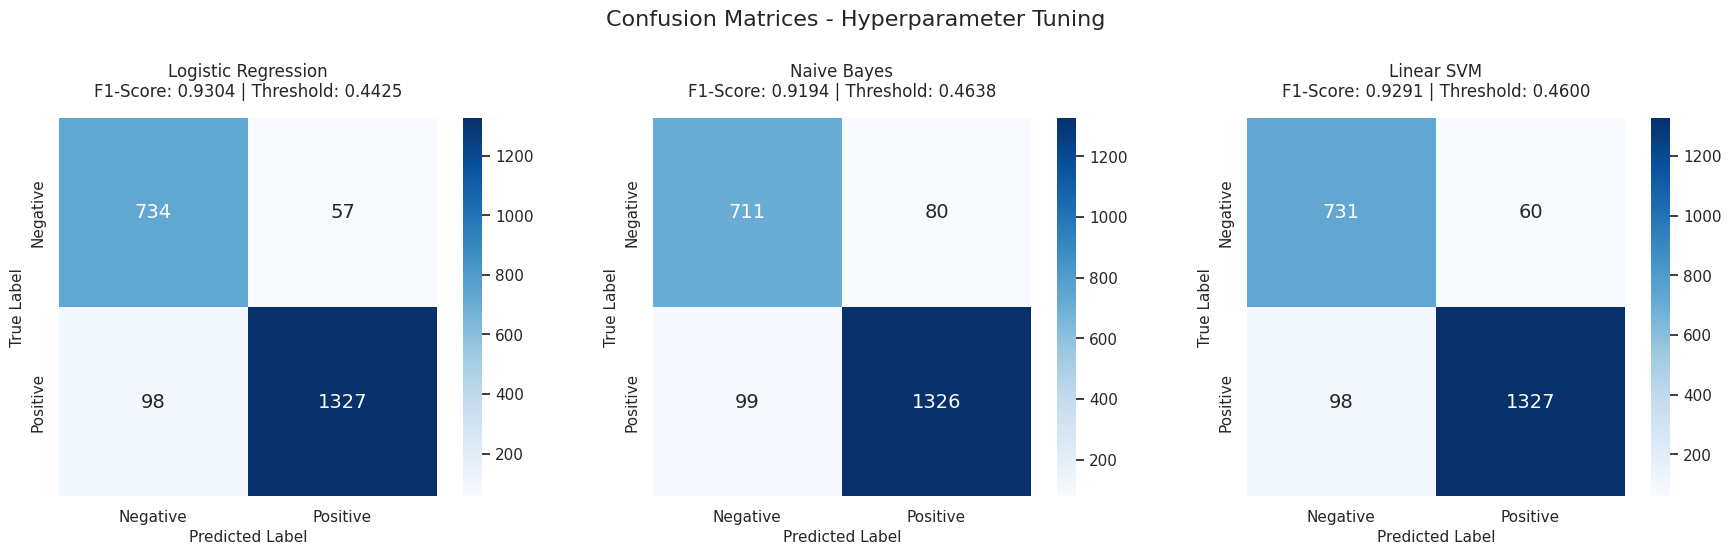


📋 CHI TIẾT CONFUSION MATRIX - LOGISTIC REGRESSION (BEST MODEL)

Confusion Matrix:
                Predicted
              Neg    Pos
Actual  Neg    734     57
        Pos     98   1327

📊 Phân tích chi tiết:
   True Negatives (TN):    734
   False Positives (FP):    57
   False Negatives (FN):    98
   True Positives (TP):   1327

📈 Metrics tính từ Confusion Matrix:
   Accuracy:   0.9301
   Precision:  0.9588
   Recall:     0.9312
   F1-Score:   0.9448



In [45]:
# Vẽ Confusion Matrices cho tất cả models sau tuning trên Test Set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("=" * 80)
print("CONFUSION MATRICES - MODELS SAU TUNING")
print("=" * 80)

# Chuẩn bị figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

# Tạo confusion matrix cho từng model
for idx, result in enumerate(tuned_test_results):
    model_name = result['Model']
    y_pred = result['y_pred']
    f1 = result['F1-Score']
    threshold = result['Threshold']
    
    # Tạo confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Vẽ confusion matrix
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        square=True,
        cbar=True,
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        ax=axes[idx],
        annot_kws={'size': 14}
    )
    
    # Thiết lập title và labels
    axes[idx].set_title(
        f'{model_name}\nF1-Score: {f1:.4f} | Threshold: {threshold:.4f}',
        fontsize=12, 
        pad=15
    )
    axes[idx].set_xlabel('Predicted Label', fontsize=11)
    axes[idx].set_ylabel('True Label', fontsize=11)
    
    # Highlight nếu là best model
    if model_name == best_tuned_model:
        for spine in axes[idx].spines.values():
            spine.set_edgecolor('gold')
            spine.set_linewidth(4)

plt.suptitle(
    'Confusion Matrices - Hyperparameter Tuning',
    fontsize=16,
    y=1.05
)
plt.tight_layout()
plt.show()

# In chi tiết confusion matrix cho best model
print("\n" + "=" * 80)
print(f"📋 CHI TIẾT CONFUSION MATRIX - {best_tuned_model.upper()} (BEST MODEL)")
print("=" * 80)

best_result = [r for r in tuned_test_results if r['Model'] == best_tuned_model][0]
best_cm = confusion_matrix(y_test, best_result['y_pred'])

print(f"\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Neg    Pos")
print(f"Actual  Neg   {best_cm[0][0]:4d}   {best_cm[0][1]:4d}")
print(f"        Pos   {best_cm[1][0]:4d}   {best_cm[1][1]:4d}")

# Tính các metrics từ confusion matrix
tn, fp, fn, tp = best_cm.ravel()

print(f"\n📊 Phân tích chi tiết:")
print(f"   True Negatives (TN):   {tn:4d}")
print(f"   False Positives (FP):  {fp:4d}")
print(f"   False Negatives (FN):  {fn:4d}")
print(f"   True Positives (TP):   {tp:4d}")

print(f"\n📈 Metrics tính từ Confusion Matrix:")
accuracy_cm = (tp + tn) / (tp + tn + fp + fn)
precision_cm = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_cm = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_cm = 2 * (precision_cm * recall_cm) / (precision_cm + recall_cm) if (precision_cm + recall_cm) > 0 else 0

print(f"   Accuracy:   {accuracy_cm:.4f}")
print(f"   Precision:  {precision_cm:.4f}")
print(f"   Recall:     {recall_cm:.4f}")
print(f"   F1-Score:   {f1_cm:.4f}")

print("\n" + "=" * 80)
